## 시험 스크립트 1 : 모델을 훈련하며 각 에폭마다의 train loss 값을 출력하고 훈련이 끝난 후 train loss & accuracy 그래프와 test Precision, Recall 등의 평가점수를 기록하는데, 이를 10번 반복하고 평균값을 구한다음 모든 기록들을 averages_1501.csv 파일로 저장하고, 10번 중에서 f1-score가 가장 높았던 모델의 Confusion Matrix 와 통합/세부평가점수를 출력하고 모델 weight를 exam.pt 에 저장 

# Multi-Class Classification with Transformer Encoder

## 1. Loading helper modules & functions

In [1]:
%load_ext autoreload
%autoreload 2
import torch as T
import torch.nn as nn
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torchinfo
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
# os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"  # Set the GPU 2 to use
device = T.device("cuda" if T.cuda.is_available() else "cpu")
device2 = T.device("cuda:1" if T.cuda.is_available() else "cpu")
# device = T.device("cpu")
# from encoding.parallel import DataParallelModel, DataParallelCriterion
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix
metric_collection = MetricCollection([
    # MulticlassAccuracy(num_classes=4, average="none").to(device),
    MulticlassPrecision(num_classes=4, average="none").to(device),
    MulticlassRecall(num_classes=4, average="none").to(device),
    MulticlassF1Score(num_classes=4, average="none").to(device),
])
metric_collection_weighted = MetricCollection([
    # MulticlassAccuracy(num_classes=4, average="weighted").to(device),
    MulticlassPrecision(num_classes=4, average="weighted").to(device),
    MulticlassRecall(num_classes=4, average="weighted").to(device),
    MulticlassF1Score(num_classes=4, average="weighted").to(device),
])
# import sklearn.datasets
from sklearn.model_selection import train_test_split
# import umap
# import umap.plot
# import shap
# import scipy as sp
# import transformers
print("Pytorch version:", T.__version__, "CUDA version:", T.version.cuda, "cuDNN version:", T.backends.cudnn.version())
print("device:", device, T.cuda.get_device_name(0), ", device2:", device2, T.cuda.get_device_name(1))

Pytorch version: 1.12.1 CUDA version: 11.3 cuDNN version: 8302
device: cuda NVIDIA RTX A6000 , device2: cuda:1 NVIDIA RTX A6000


## 2. Implementing backbone of Transformer-based Classifier

In [2]:
# feature 개수 확인 및 설정
hf = h5py.File('STAD_Dataset3_ALL_exam.h5', 'r')
X_DATA = np.array(hf.get('X'))
Y_DATA = np.array(hf.get('Y'))
print('X_DATA.shape :', X_DATA.shape, ', X_DATA.dtype :', X_DATA.dtype)
print('Y_DATA.shape :', Y_DATA.shape, '     , Y_DATA.dtype :', Y_DATA.dtype)
hf.close()

n_feature = X_DATA.shape[1]
print("\nThe number of feature :", n_feature)

X_DATA.shape : (407, 1501) , X_DATA.dtype : float64
Y_DATA.shape : (407,)      , Y_DATA.dtype : int8

The number of feature : 1501


In [3]:
class STAD_Dataset(T.utils.data.Dataset):
    def __init__(self, src_file):
        hf = h5py.File(src_file, 'r')
        if 'X_Train' in hf.keys() :
            # x = np.array(hf.get('X_Train')).astype('int64')
            x = np.array(hf.get('X_Train'))
            y = np.array(hf.get('Y_Train')).astype('int8')
        else :
            # x = np.array(hf.get('X_Test')).astype('int64')
            x = np.array(hf.get('X_Test'))
            y = np.array(hf.get('Y_Test')).astype('int8')
        hf.close()

        # self.x_data = T.tensor(x, dtype=T.int64).to(device)
        self.x_data = T.tensor(x, dtype=T.float32).to(device)
        self.y_data = T.tensor(y, dtype=T.int64).to(device)  

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx] 
        return x, y  

In [4]:
class PositionalEncoding(T.nn.Module):  
    def __init__(self, d_model: int, dropout: float=0.1, max_len: int=n_feature):
        super(PositionalEncoding, self).__init__()  
        self.dropout = T.nn.Dropout(p=dropout)
        pe = T.zeros(max_len, d_model)  
        position = T.arange(0, max_len, dtype=T.float32).unsqueeze(1)
        div_term = T.exp(T.arange(0, d_model, 2).float() * (-np.log(10_000.0) / d_model))
        pe[:, 0::2] = T.sin(position * div_term)
        pe[:, 1::2] = T.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # 이게 없으면 나중에 forward 에서 pe값을 못 찾아 에러남

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [5]:
# E = number of cases that all features can express in integer (feature=token) 
# D = #Embedding Dimension ; I = #input features ; F = #fc1 layer hidden nodes ; drop = dropout rate
E = 320 ; D = 8 ; I = n_feature ; F = 8 ; drop = 0.1
class Transformer_Classifier(T.nn.Module):  # 1501 -> 12008 -> Transformer -> FC -> 4
    def __init__(self):
        super(Transformer_Classifier, self).__init__() 
        # numeric pseudo-embedding, dim=D
        # self.embed = Special_Embedding_Layer(I, I*D)  # I input features, each goes to D 
        self.embed = T.nn.Embedding(E, D)  # I input features, each goes to D
        self.pos_enc = PositionalEncoding(D, dropout=drop)  # positional embedding
        self.enc_layer = T.nn.TransformerEncoderLayer(d_model=D, nhead=4, dim_feedforward=D, 
                         dropout=drop, batch_first=True)  # d_model should be divisible by nhead
        self.trans_enc = T.nn.TransformerEncoder(self.enc_layer, num_layers=3)  # default 6 layers 
        # STAD Dataset has I input features per each sample
        self.dropout = nn.Dropout(drop)
        # self.fc1 = T.nn.Linear(D*I, F)  # F hidden nodes
        # self.fc2 = T.nn.Linear(F, 4)    # 4 classes
        self.fc3 = T.nn.Linear(D*I, 4)    # 4 classes (GX, G1, G2, G3)

    def forward(self, x):
        # x = I input features, fixed length
        z = self.embed(x.int())  # I inputs to I*D embeds
        z = z.reshape(-1, I, D) 
        z = self.pos_enc(z) 
        z = self.trans_enc(z) 
        z = z.reshape(-1, D*I)  # torch.Size([batch_size, D*I])
        # z = self.dropout(z)
        # z = self.fc1(z)
        # z = T.tanh(z)
        z = self.dropout(z)
        z = self.fc3(z)
        z = T.log_softmax(z, dim=1)  # later followed by NLL Loss()
        return z

In [6]:
net = Transformer_Classifier().to(device)
batchsize = 1
torchinfo.summary(net, input_size=(batchsize, n_feature),  dtypes=[T.long],
col_names=["input_size","output_size","num_params","params_percent","trainable"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Param %                   Trainable
Transformer_Classifier                        [1, 1501]                 [1, 4]                    464                         0.88%                   True
├─Embedding: 1-1                              [1, 1501]                 [1, 1501, 8]              2,560                       4.88%                   True
├─PositionalEncoding: 1-2                     [1, 1501, 8]              [1, 1501, 8]              --                             --                   --
│    └─Dropout: 2-1                           [1, 1501, 8]              [1, 1501, 8]              --                             --                   --
├─TransformerEncoder: 1-3                     [1, 1501, 8]              [1, 1501, 8]              --                             --                   True
│    └─ModuleList: 2-2                        --                     

## 3. Training model

############################## Trining 1 ##############################

X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file
  Dataloader for training prepared with batch_size 8
Creating Transformer network...
Preparation for model training complete.

bat_size =   8 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  18 

Starting training
epoch =    1  |  loss =   5.0418  |  lr = 0.00010000
epoch =    2  |  loss =   4.0705  |  lr = 0.00009900
epoch =    3  |  loss =   3.7436  |  lr = 0.00009801
epoch =    4  |  loss =   2.9912  |  lr = 0.00009703
epoch =    5  |  loss =   2.5140  | 

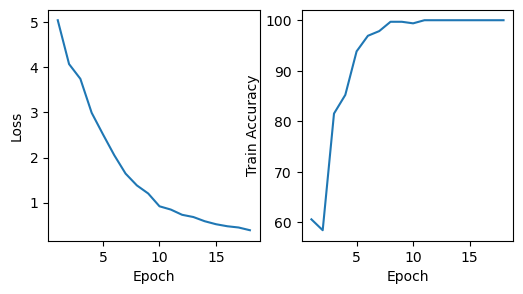

{'MulticlassPrecision': tensor(0.5502, device='cuda:0'), 'MulticlassRecall': tensor(0.5366, device='cuda:0'), 'MulticlassF1Score': tensor(0.5319, device='cuda:0')} 

best record renewed

############################## Trining 2 ##############################

X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file
  Dataloader for training prepared with batch_size 8
Creating Transformer network...
Preparation for model training complete.

bat_size =   8 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  18 

Starting training
epoch =    1  |  loss =   5.1458  |  lr = 0.00010000
epoch = 

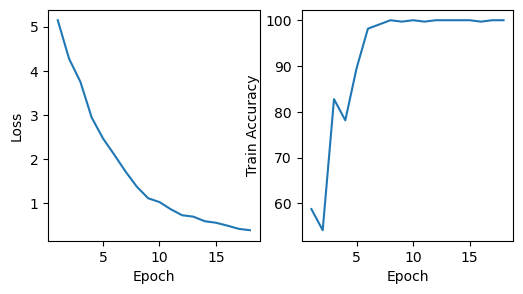

{'MulticlassPrecision': tensor(0.5180, device='cuda:0'), 'MulticlassRecall': tensor(0.5366, device='cuda:0'), 'MulticlassF1Score': tensor(0.5262, device='cuda:0')} 

############################## Trining 3 ##############################

X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file
  Dataloader for training prepared with batch_size 8
Creating Transformer network...
Preparation for model training complete.

bat_size =   8 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  18 

Starting training
epoch =    1  |  loss =   5.4169  |  lr = 0.00010000
epoch =    2  |  loss =   4.4

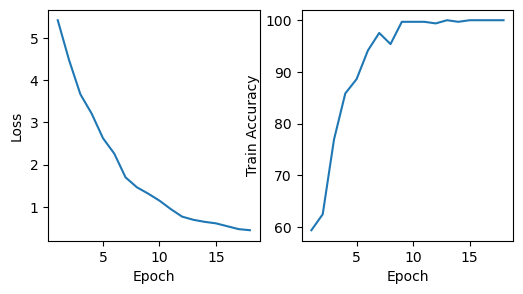

{'MulticlassPrecision': tensor(0.6190, device='cuda:0'), 'MulticlassRecall': tensor(0.6341, device='cuda:0'), 'MulticlassF1Score': tensor(0.6215, device='cuda:0')} 

best record renewed

############################## Trining 4 ##############################

X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file
  Dataloader for training prepared with batch_size 8
Creating Transformer network...
Preparation for model training complete.

bat_size =   8 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  18 

Starting training
epoch =    1  |  loss =   4.9407  |  lr = 0.00010000
epoch = 

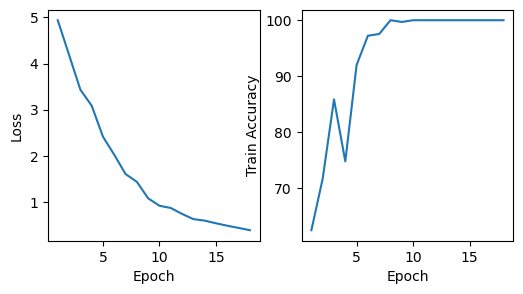

{'MulticlassPrecision': tensor(0.6232, device='cuda:0'), 'MulticlassRecall': tensor(0.6341, device='cuda:0'), 'MulticlassF1Score': tensor(0.6238, device='cuda:0')} 

best record renewed

############################## Trining 5 ##############################

X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file
  Dataloader for training prepared with batch_size 8
Creating Transformer network...
Preparation for model training complete.

bat_size =   8 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  18 

Starting training
epoch =    1  |  loss =   5.2691  |  lr = 0.00010000
epoch = 

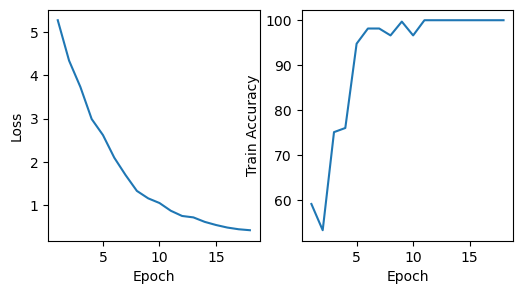

{'MulticlassPrecision': tensor(0.4301, device='cuda:0'), 'MulticlassRecall': tensor(0.4268, device='cuda:0'), 'MulticlassF1Score': tensor(0.4234, device='cuda:0')} 

############################## Trining 6 ##############################

X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file
  Dataloader for training prepared with batch_size 8
Creating Transformer network...
Preparation for model training complete.

bat_size =   8 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  18 

Starting training
epoch =    1  |  loss =   5.4616  |  lr = 0.00010000
epoch =    2  |  loss =   4.3

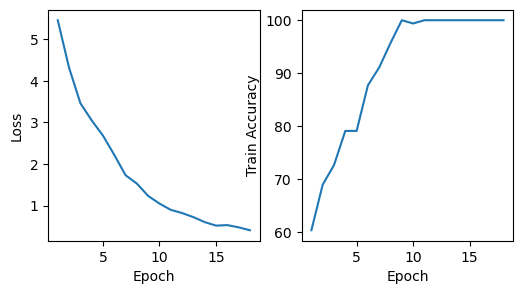

{'MulticlassPrecision': tensor(0.5452, device='cuda:0'), 'MulticlassRecall': tensor(0.5366, device='cuda:0'), 'MulticlassF1Score': tensor(0.5364, device='cuda:0')} 

############################## Trining 7 ##############################

X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file
  Dataloader for training prepared with batch_size 8
Creating Transformer network...
Preparation for model training complete.

bat_size =   8 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  18 

Starting training
epoch =    1  |  loss =   4.7747  |  lr = 0.00010000
epoch =    2  |  loss =   4.2

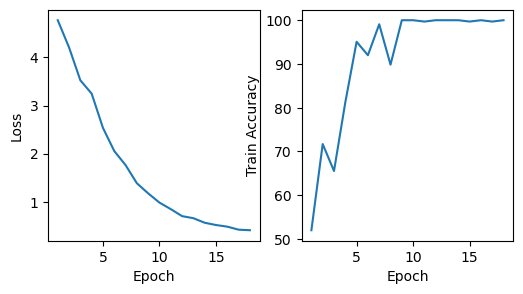

{'MulticlassPrecision': tensor(0.4212, device='cuda:0'), 'MulticlassRecall': tensor(0.4756, device='cuda:0'), 'MulticlassF1Score': tensor(0.4405, device='cuda:0')} 

############################## Trining 8 ##############################

X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file
  Dataloader for training prepared with batch_size 8
Creating Transformer network...
Preparation for model training complete.

bat_size =   8 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  18 

Starting training
epoch =    1  |  loss =   5.6313  |  lr = 0.00010000
epoch =    2  |  loss =   4.1

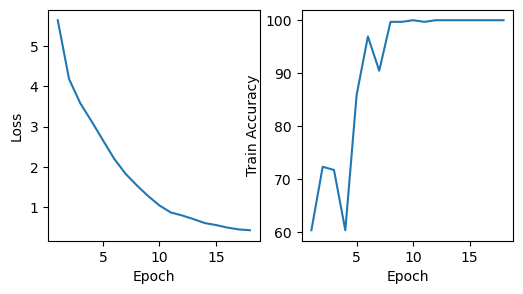

{'MulticlassPrecision': tensor(0.5134, device='cuda:0'), 'MulticlassRecall': tensor(0.5244, device='cuda:0'), 'MulticlassF1Score': tensor(0.5148, device='cuda:0')} 

############################## Trining 9 ##############################

X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file
  Dataloader for training prepared with batch_size 8
Creating Transformer network...
Preparation for model training complete.

bat_size =   8 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  18 

Starting training
epoch =    1  |  loss =   5.1352  |  lr = 0.00010000
epoch =    2  |  loss =   4.1

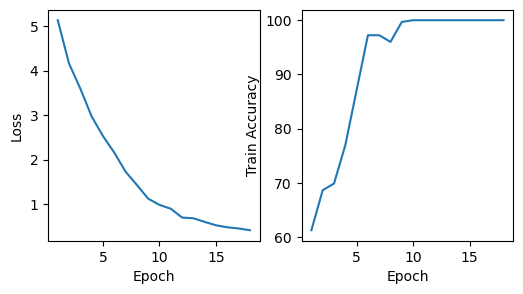

{'MulticlassPrecision': tensor(0.6012, device='cuda:0'), 'MulticlassRecall': tensor(0.6220, device='cuda:0'), 'MulticlassF1Score': tensor(0.6104, device='cuda:0')} 

############################## Trining 10 ##############################

X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)

Making tensor dataset of STAD samples on device cuda NVIDIA RTX A6000
  325 training dataset created from an h5 file
  82 test dataset created from an h5 file
  Dataloader for training prepared with batch_size 8
Creating Transformer network...
Preparation for model training complete.

bat_size =   8 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  18 

Starting training
epoch =    1  |  loss =   5.1643  |  lr = 0.00010000
epoch =    2  |  loss =   3.

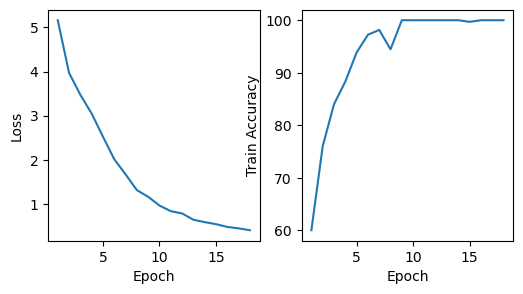

{'MulticlassPrecision': tensor(0.5087, device='cuda:0'), 'MulticlassRecall': tensor(0.5244, device='cuda:0'), 'MulticlassF1Score': tensor(0.5150, device='cuda:0')} 



In [ ]:
max_F1 = 0
final_loss_list_10 = []
precision_list_10 = []
recall_list_10 = []
f1score_list_10 = []
best_loss_list = []
best_accuracy_list = []
best_net = 0
best_train_ds = 0
best_test_ds = 0

for i in range(10):

    print("############################## Trining", i+1, "##############################\n")

    ########## 3-0. Data Random Splitting ##########

    # 1. Train : Test 를 레이블 비율을 균등하게 유지하면서 8 : 2로 랜덤하게 나눔
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_DATA, Y_DATA, test_size=0.2, stratify=Y_DATA, random_state=(2*i+1))

    # 2. Train 데이터 파일로 저장
    hf = h5py.File('STAD_Dataset3_Train_exam.h5', 'w')
    hf.create_dataset('X_Train', data=X_Train)
    hf.create_dataset('Y_Train', data=Y_Train)
    hf.close()
    # 3. Test 데이터 파일로 저장 
    hf = h5py.File('STAD_Dataset3_Test_exam.h5', 'w')
    hf.create_dataset('X_Test', data=X_Test)
    hf.create_dataset('Y_Test', data=Y_Test)
    hf.close()

    print('X_Train.shape : ', X_Train.shape)
    print('Y_Train.shape : ', Y_Train.shape)
    print('X_Test.shape  : ', X_Test.shape)
    print('Y_Test.shape  : ', Y_Test.shape)
    # "Y_Test", Y_Test # 매번 랜덤으로 들어가는 지 확인


    ########## 3-1. Lodaing Dataset ##########

    # 0. setup
    print("\nMaking tensor dataset of STAD samples on device", device, T.cuda.get_device_name(0))
    np.random.seed(1)  
    T.manual_seed(1)  

    # 1. create Dataset
    train_file = "./STAD_Dataset3_Train_exam.h5"
    train_ds = STAD_Dataset(train_file)
    print(" ", len(train_ds), "training dataset created from an h5 file")

    test_file = "./STAD_Dataset3_Test_exam.h5"
    test_ds = STAD_Dataset(test_file)
    print(" ", len(test_ds), "test dataset created from an h5 file")

    bat_size = 8
    train_ldr = T.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)
    print("  Dataloader for training prepared with batch_size", bat_size)
    # test_ldr = T.utils.data.DataLoader(test_ds, batch_size=2, shuffle=False)


    ########## 3-2. Training model ##########

    print("Creating Transformer network...")
    # net = Transformer_Classifier().to(device)
    net = nn.DataParallel(Transformer_Classifier()).to(device)
    # net = DataParallelModel(Transformer_Classifier()).to(device) # for Multi-GPU 
    # net.double() # 모델 내 데이터들을 전체적으로 float32에서 float64로 만들어 줌. 대신 훈련시간 6배 더 걸림.
    # net.half() # float16으로 만들어 주어서 정말 GPU가 반만 드는데 loss가 줄어들지 않는 경우가 다반사
    print("Preparation for model training complete.")

    max_epochs = 18
    ep_log_interval = 1
    lrn_rate = 0.0001

    loss_func = T.nn.NLLLoss()  # assumes log-softmax()
    # loss_func = DataParallelCriterion(T.nn.NLLLoss())  # assumes log-softmax()
    # optimizer = T.optim.SGD(net.parameters(), lr=lrn_rate)
    optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate, weight_decay=0.1)
    scheduler = T.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.99 ** epoch, last_epoch=-1, verbose=False)

    print("\nbat_size = %3d " % bat_size)
    print("loss = " + str(loss_func))
    print("optimizer = ", optimizer)
    # print("lrn_rate = %0.5f " % lrn_rate)
    print("max_epochs = %3d " % max_epochs)

    print("\nStarting training")
    net.train()  # set mode

    loss_list = []
    accuracy_list = []
    test_accuracy_list = []
    for epoch in range(0, max_epochs):
        ep_loss = 0.0  # for one full epoch
        for (batch_idx, batch) in enumerate(train_ldr):
            (X, y) = batch  # X = genes, y = labels
            optimizer.zero_grad()
            # with T.autocast(device_type="cuda"): # for auto-mixed precision
            oupt = net(X)
            loss_val = loss_func(oupt, y)  # a tensor
            # loss_val = loss_func(oupt, (y[0:5], y[5:10].to(device2)))  # a tuple tensor for DataParallelCriterion
            ep_loss += loss_val.item()  # accumulate
            loss_val.backward()  # compute grads
            optimizer.step()     # update weights
        if epoch % ep_log_interval == 0:
            print("epoch = %4d  |  loss = %8.4f  |  lr = %8.8f" % (epoch+1, ep_loss/bat_size, optimizer.param_groups[0]['lr']))
            # net.eval()
        scheduler.step()

        # train loss & accuracy 그래프를 그리기 위한 코드
        with T.no_grad(): 
            total = 0
            correct=0
            for X, Y in train_ldr:
                outputs = net(X)
                _,predict = T.max(outputs.data, 1)
                total += Y.size(0)
                correct += (predict==Y).sum()
        avg_cost = ep_loss / bat_size
        loss_list.append(avg_cost)
        accuracy = 100 * correct / total
        accuracy_list.append(accuracy.cpu().numpy())

    print("Done ") 

    # 훈련과정 전반에 걸친 Loss & Accuracy 그래프
    epochs = np.arange(1, max_epochs+1)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epochs, loss_list)
    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.plot(epochs, accuracy_list)
    plt.show()

    final_loss_list_10.append(loss_list[-1]) # 시험1 기준1을 위한

    net.eval()
    with T.no_grad():
        output_test = net(test_ds.x_data)
    target_test = test_ds.y_data
    preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
    print(metric_collection_weighted(preds_test, target_test),'\n')

    # 시험1 기준2를 위한
    precision_list_10.append(MulticlassPrecision(num_classes=4, average="weighted").to(device)(preds_test, target_test))    
    recall_list_10.append(MulticlassRecall(num_classes=4, average="weighted").to(device)(preds_test, target_test))    

    current_F1 = MulticlassF1Score(num_classes=4, average="weighted").to(device)(preds_test, target_test)
    f1score_list_10.append(current_F1)    
    if current_F1 > max_F1 :
        max_F1 = current_F1
        best_loss_list = loss_list
        best_accuracy_list = accuracy_list
        best_net = net
        best_train_ds = train_ds
        best_test_ds = test_ds
        print("best record renewed\n")

### 10번 훈련마다의 마지막 loss 값 리스트

In [8]:
final_loss_list_10 

[0.39028290705755353,
 0.38836033502593637,
 0.4484763229265809,
 0.3860295554623008,
 0.42823206703178585,
 0.4070012541487813,
 0.4094636240042746,
 0.43767593102529645,
 0.41101695550605655,
 0.4016410121694207]

### 10번 훈련에서의 각 precision 값들과 그 평균

In [9]:
precision_sum = 0
for p in precision_list_10:
    precision_sum += p
precision_list_10,  ("Precision 10회 평균 :", precision_sum/10)

([tensor(0.5502, device='cuda:0'),
  tensor(0.5180, device='cuda:0'),
  tensor(0.6190, device='cuda:0'),
  tensor(0.6232, device='cuda:0'),
  tensor(0.4301, device='cuda:0'),
  tensor(0.5452, device='cuda:0'),
  tensor(0.4212, device='cuda:0'),
  tensor(0.5134, device='cuda:0'),
  tensor(0.6012, device='cuda:0'),
  tensor(0.5087, device='cuda:0')],
 ('Precision 10회 평균 :', tensor(0.5330, device='cuda:0')))

### 10번 훈련에서의 각 recall 값들과 그 평균

In [10]:
recall_sum = 0
for p in recall_list_10:
    recall_sum += p
recall_list_10,  ("Recall 10회 평균 :", recall_sum/10)

([tensor(0.5366, device='cuda:0'),
  tensor(0.5366, device='cuda:0'),
  tensor(0.6341, device='cuda:0'),
  tensor(0.6341, device='cuda:0'),
  tensor(0.4268, device='cuda:0'),
  tensor(0.5366, device='cuda:0'),
  tensor(0.4756, device='cuda:0'),
  tensor(0.5244, device='cuda:0'),
  tensor(0.6220, device='cuda:0'),
  tensor(0.5244, device='cuda:0')],
 ('Recall 10회 평균 :', tensor(0.5451, device='cuda:0')))

### 10번 훈련에서의 각 F1-Score 값들과 그 평균

In [11]:
f1score_sum = 0
for p in f1score_list_10:
    f1score_sum += p
f1score_list_10,  ("F1-Score 10회 평균 :", f1score_sum/10)

([tensor(0.5319, device='cuda:0'),
  tensor(0.5262, device='cuda:0'),
  tensor(0.6215, device='cuda:0'),
  tensor(0.6238, device='cuda:0'),
  tensor(0.4234, device='cuda:0'),
  tensor(0.5364, device='cuda:0'),
  tensor(0.4405, device='cuda:0'),
  tensor(0.5148, device='cuda:0'),
  tensor(0.6104, device='cuda:0'),
  tensor(0.5150, device='cuda:0')],
 ('F1-Score 10회 평균 :', tensor(0.5344, device='cuda:0')))

### 각종 값들과 평균 csv 파일로 저장

In [12]:
precision_list = [p.detach().cpu().numpy() for p in precision_list_10]
precision_list.append((precision_sum/10).detach().cpu().numpy())
recall_list = [p.detach().cpu().numpy() for p in recall_list_10]
recall_list.append((recall_sum/10).detach().cpu().numpy())
f1score_list = [p.detach().cpu().numpy() for p in f1score_list_10]
f1score_list.append((f1score_sum/10).detach().cpu().numpy())
f1score_list

[array(0.53192496, dtype=float32),
 array(0.5262368, dtype=float32),
 array(0.6215142, dtype=float32),
 array(0.62377495, dtype=float32),
 array(0.42336893, dtype=float32),
 array(0.5363848, dtype=float32),
 array(0.4405249, dtype=float32),
 array(0.5147705, dtype=float32),
 array(0.6103683, dtype=float32),
 array(0.51502573, dtype=float32),
 array(0.53438944, dtype=float32)]

In [13]:
averages_1501_df = pd.DataFrame({'Train':np.arange(1,len(precision_list)+1),
                                 'Precision':precision_list, 
                                 'Recall':recall_list, 
                                 'F1-Score':f1score_list})  
averages_1501_df.iloc[(-1,0)] = '평균'
averages_1501_df

,Train,Precision,Recall,F1-Score
0,1,0.5501809,0.53658533,0.53192496
1,2,0.5179776,0.53658533,0.5262368
2,3,0.6190061,0.63414633,0.6215142
3,4,0.6232384,0.63414633,0.62377495
4,5,0.43010116,0.42682928,0.42336893
5,6,0.54521483,0.53658533,0.5363848
6,7,0.42120296,0.47560975,0.4405249
7,8,0.51341677,0.5243902,0.5147705
8,9,0.6011565,0.6219512,0.6103683
9,10,0.50874865,0.5243902,0.51502573


In [14]:
averages_1501_df.to_csv('./averages_1501.csv')

## 4. Evaluating model with the best weight of 10

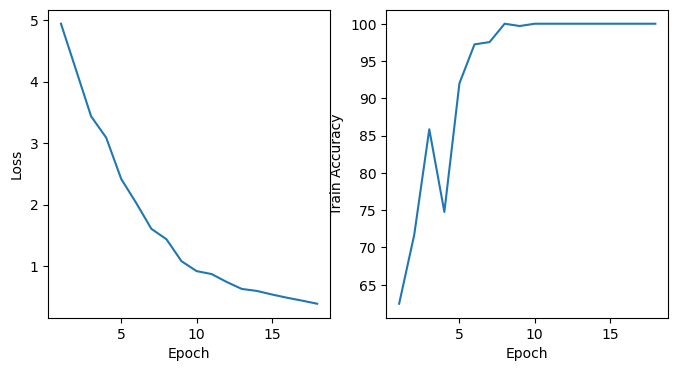

In [15]:
# 10번 중 가장 잘 나온 Loss & Accuracy 그래프
epochs = np.arange(1, max_epochs+1)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, best_loss_list)
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.plot(epochs, best_accuracy_list)

In [16]:
print("Train Dataset 통합 평가지수(Precision/Recall/F1Score)")
best_net.eval()
with T.no_grad():
    output_train = best_net(best_train_ds.x_data)
target_train = best_train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_train, target_train)

Train Dataset 통합 평가지수(Precision/Recall/F1Score)


{'MulticlassPrecision': tensor(1., device='cuda:0'),
 'MulticlassRecall': tensor(1., device='cuda:0'),
 'MulticlassF1Score': tensor(1., device='cuda:0')}

In [17]:
print("Test Dataset 통합 평가지수(Precision/Recall/F1Score)")
best_net.eval()
with T.no_grad():
    output_test = best_net(best_test_ds.x_data)
target_test = best_test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_test, target_test)

Test Dataset 통합 평가지수(Precision/Recall/F1Score)


{'MulticlassPrecision': tensor(0.6232, device='cuda:0'),
 'MulticlassRecall': tensor(0.6341, device='cuda:0'),
 'MulticlassF1Score': tensor(0.6238, device='cuda:0')}

### 4-1. Evaluating model with Train Dataset

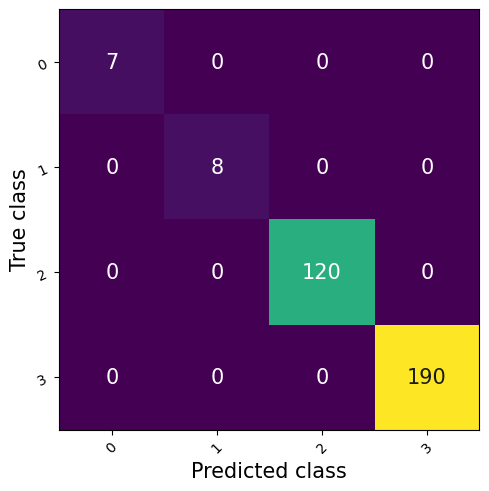

In [18]:
target_train = best_train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_train = MulticlassConfusionMatrix(num_classes=4).to(device)
metric_train.update(preds_train, target_train)
fig_, ax_ = metric_train.plot()

In [19]:
print("Train Dataset 세부 평가지수(레이블 각각의 Precision/Recall/F1Score)")
metric_collection(preds_train, target_train)

Train Dataset 세부 평가지수(레이블 각각의 Precision/Recall/F1Score)


{'MulticlassPrecision': tensor([1., 1., 1., 1.], device='cuda:0'),
 'MulticlassRecall': tensor([1., 1., 1., 1.], device='cuda:0'),
 'MulticlassF1Score': tensor([1., 1., 1., 1.], device='cuda:0')}

### 4-2. Evaluating model with Test Dataset

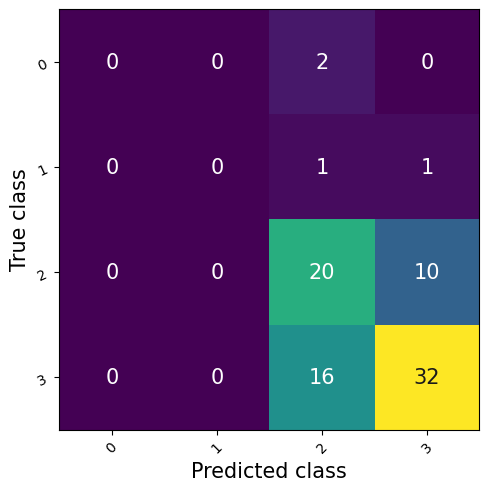

In [20]:
target_test = best_test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_test = MulticlassConfusionMatrix(num_classes=4).to(device)
metric_test.update(preds_test, target_test)
fig_, ax_ = metric_test.plot()

In [21]:
print("Train Dataset 세부 평가지수(레이블 각각의 Precision/Recall/F1Score)")
metric_collection(preds_test, target_test)

Train Dataset 세부 평가지수(레이블 각각의 Precision/Recall/F1Score)


{'MulticlassPrecision': tensor([0.0000, 0.0000, 0.5128, 0.7442], device='cuda:0'),
 'MulticlassRecall': tensor([0.0000, 0.0000, 0.6667, 0.6667], device='cuda:0'),
 'MulticlassF1Score': tensor([0.0000, 0.0000, 0.5797, 0.7033], device='cuda:0')}

## 5. Save model

In [22]:
# # 단일 GPU에서 훈련시킨 경우
# file_name = "./Model_save/exam.pt"
# T.save(best_net.state_dict(), file_name)  
# print("\ntrained model state saved")

In [23]:
# 여러 GPU에서 DataParallel로 훈련시키고 나서 weight를 통합해서 저장하는 방법 
# (나중에 불러낸 후 단일 GPU에서 추론 해야만 할 때를 대비하기 위함임) 
# file_name = "./Model_save/exam.pt"
# T.save(net.module.state_dict(), file_name)  
# print("\ntrained model state saved")
file_name = "./exam.pt"
T.save(best_net.module.state_dict(), file_name)  
print("\ntrained model state saved")


trained model state saved
